#1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#2. Load Dataset and Preprocessing

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Python Project/Time Series Forecasting/AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.index

DatetimeIndex(['2004-12-31 01:00:00', '2004-12-31 02:00:00',
               '2004-12-31 03:00:00', '2004-12-31 04:00:00',
               '2004-12-31 05:00:00', '2004-12-31 06:00:00',
               '2004-12-31 07:00:00', '2004-12-31 08:00:00',
               '2004-12-31 09:00:00', '2004-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

#3. Plot Dataset

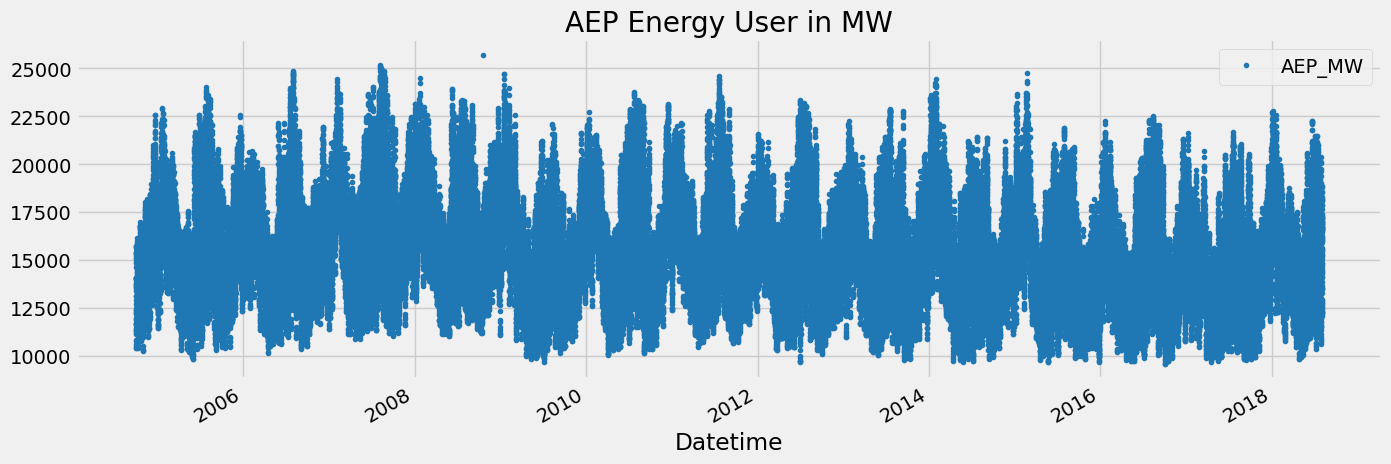

In [4]:
df.plot(style='.',figsize=(15,5), color=color_pal[0], title='AEP Energy User in MW')
plt.show()

##3.1 Outlier Analysis and removal

<Axes: ylabel='Frequency'>

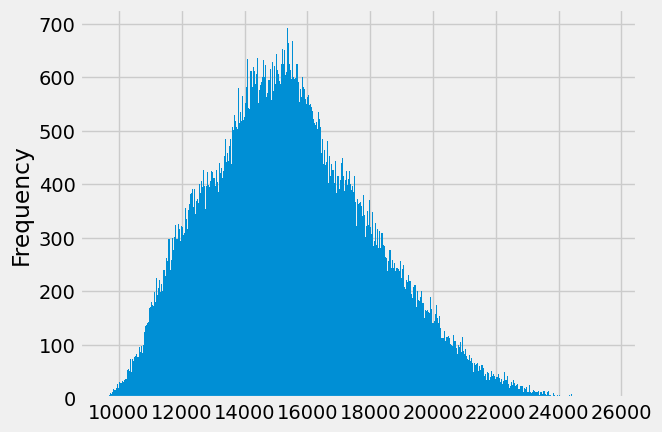

In [5]:
df['AEP_MW'].plot(kind='hist', bins=500)

In [6]:
#df.query('AEP_MW < 10_000').plot(figsize=(15,5), style='.', color=color_pal[5], title="outliers")

In [7]:
#df = df.query('AEP_MW < 10_000').copy()

#4. Train & Test Split

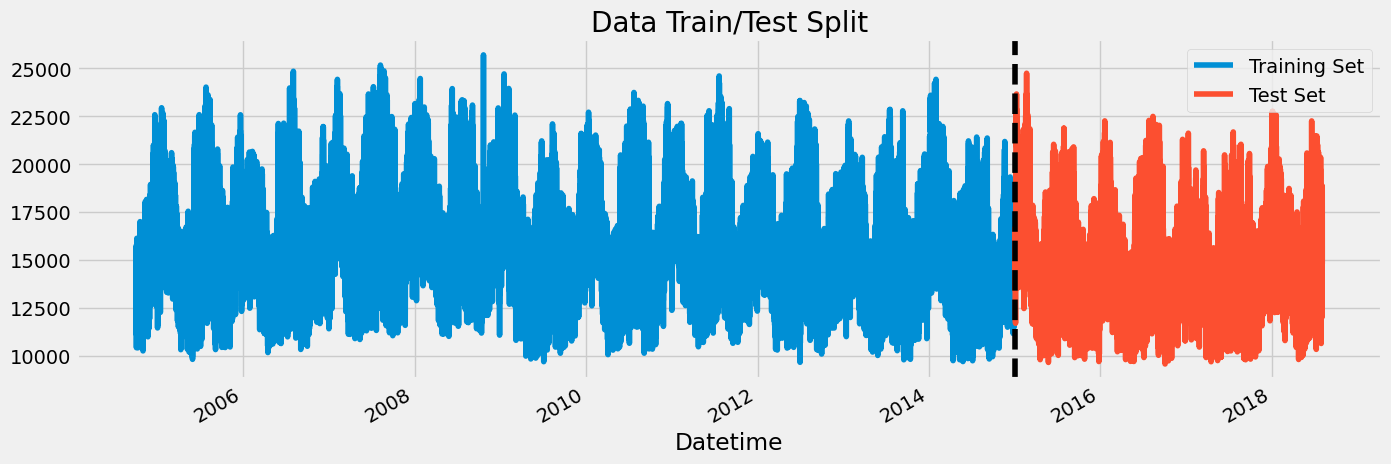

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax,label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

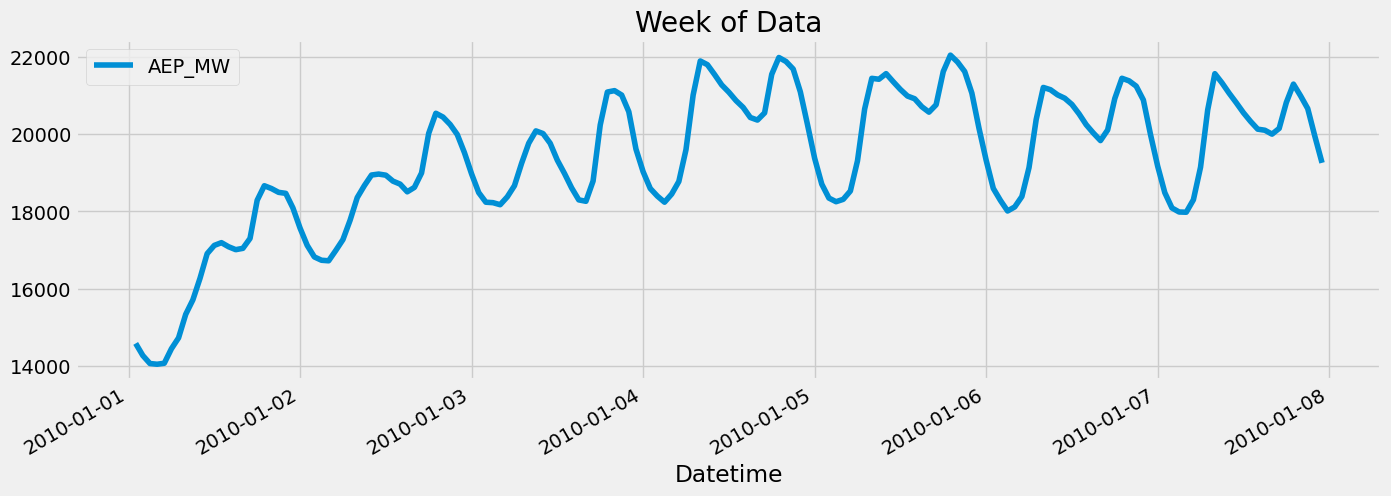

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
plt.show()

##4.1 Time Series Split

In [10]:
from sklearn.model_selection import TimeSeriesSplit

In [11]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

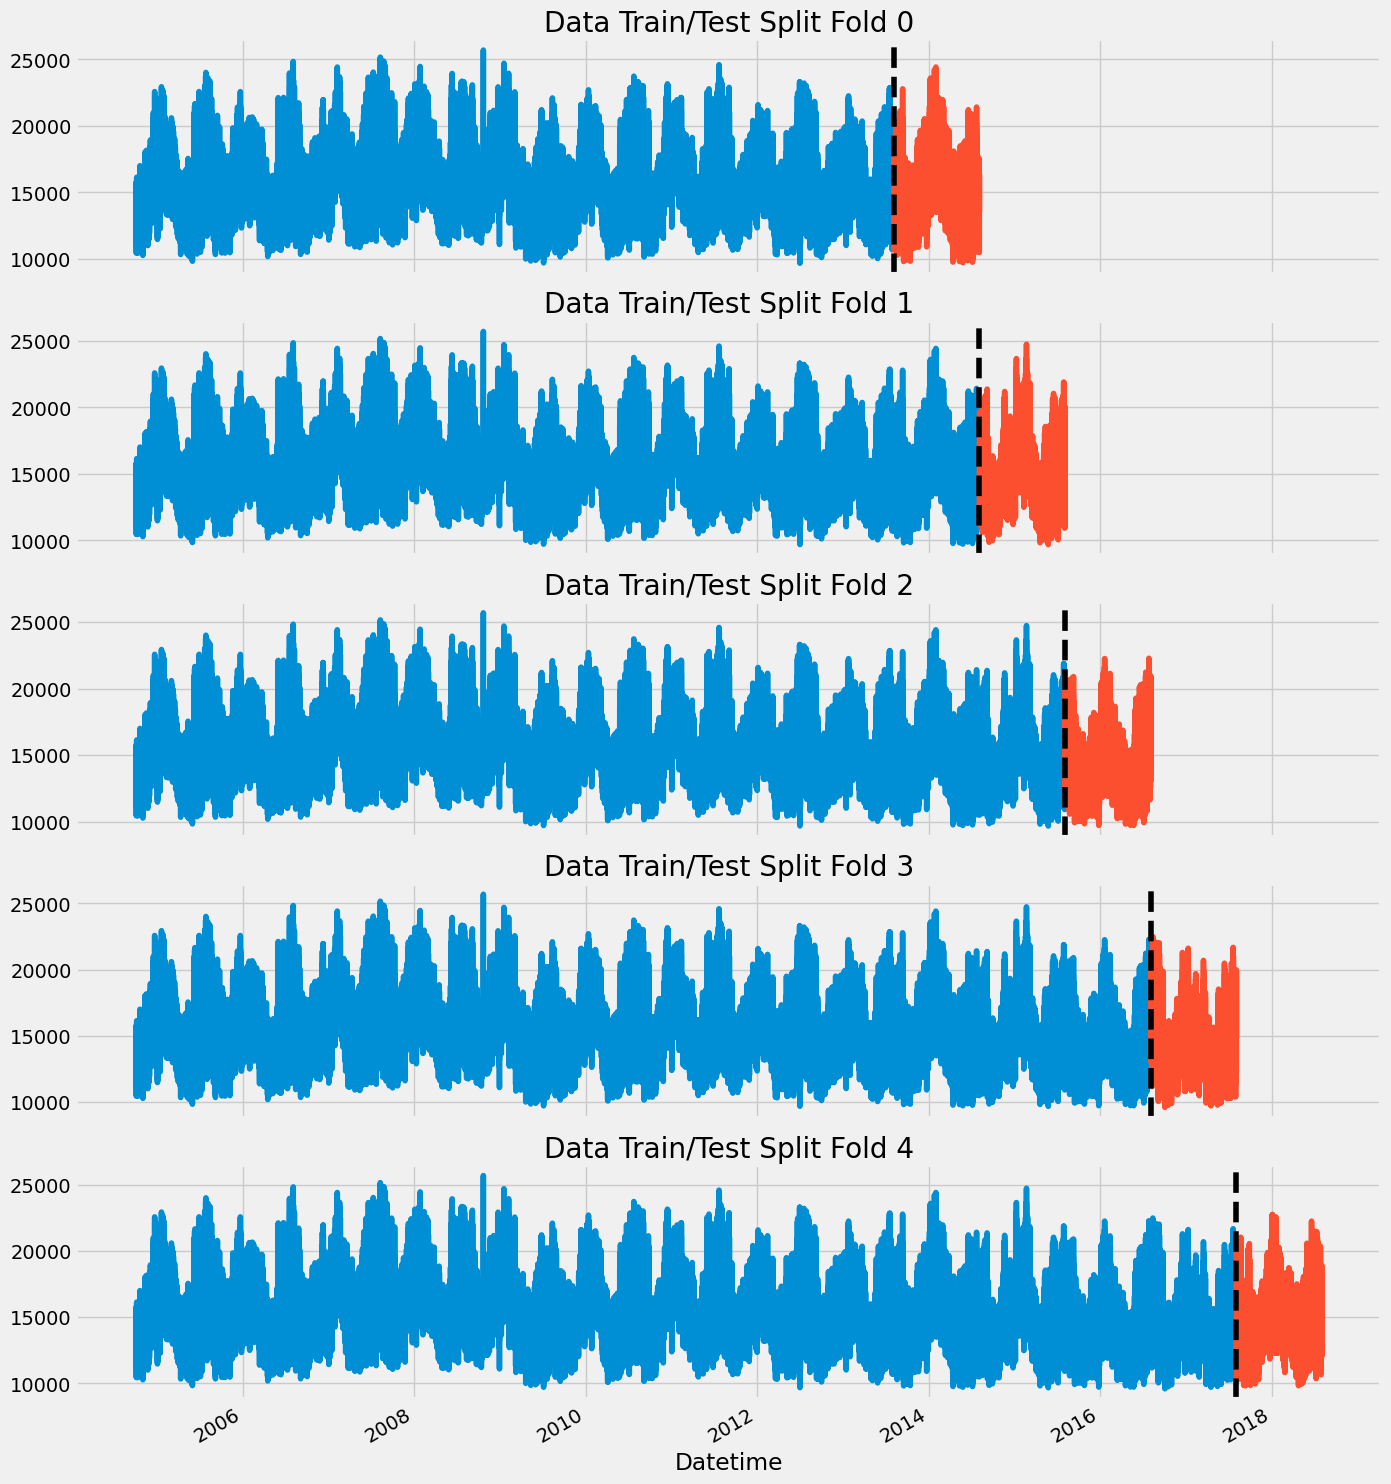

In [12]:
fig, axs = plt.subplots(5,1, figsize=(15,20),
                       sharex=True)

fold = 0
for train_index,val_index in tss.split(df):
    train = df.iloc[train_index]
    test= df.iloc[val_index]
    train['AEP_MW'].plot(ax=axs[fold],
                         label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                        label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

##4.2 Forecasting Horizon Explained
The forecast horizon is the lenght of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).

In [13]:
def create_feature(df):
    """
    Create time series feature absed on time series index.
    """
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_feature(df)

##4.3 Lag Features
What was the target (X) days in the past.

In [14]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)

#### Train Using Cross Validation

In [16]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_index,val_index in tss.split(df):
    train = df.iloc[train_index]
    test= df.iloc[val_index]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test,y_test)],
            verbose=100)
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

<ipython-input-13-ab95bd213bc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-13-ab95bd213bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-13-ab95bd213bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[06:43:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15898.36248	validation_1-rmse:15264.17093
[100]	validation_0-rmse:6031.01245	validation_1-rmse:5645.57605
[200]	validation_0-rmse:2654.67736	validation_1-rmse:2430.85872
[300]	validation_0-rmse:1711.09082	validation_1-rmse:1642.21380
[400]	validation_0-rmse:1491.06784	validation_1-rmse:1550.80241
[459]	validation_0-rmse:1448.41369	validation_1-rmse:1554.53803
[06:43:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15835.43826	validation_1-rmse:15221.94439


<ipython-input-13-ab95bd213bc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-13-ab95bd213bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-13-ab95bd213bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[100]	validation_0-rmse:6007.65137	validation_1-rmse:5714.44882
[200]	validation_0-rmse:2645.38093	validation_1-rmse:2505.70100
[300]	validation_0-rmse:1707.68248	validation_1-rmse:1618.95546
[400]	validation_0-rmse:1500.38894	validation_1-rmse:1454.94105
[500]	validation_0-rmse:1441.76223	validation_1-rmse:1430.37621
[600]	validation_0-rmse:1410.26687	validation_1-rmse:1425.15359
[700]	validation_0-rmse:1390.38107	validation_1-rmse:1425.97880
[721]	validation_0-rmse:1386.40888	validation_1-rmse:1427.37651
[06:44:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15779.22927	validation_1-rmse:14549.83302


<ipython-input-13-ab95bd213bc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-13-ab95bd213bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-13-ab95bd213bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[100]	validation_0-rmse:5985.41875	validation_1-rmse:5100.83909
[200]	validation_0-rmse:2635.48335	validation_1-rmse:2053.91235
[300]	validation_0-rmse:1703.12036	validation_1-rmse:1502.77912
[379]	validation_0-rmse:1521.12253	validation_1-rmse:1518.00038
[06:45:14] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-13-ab95bd213bc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-13-ab95bd213bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-13-ab95bd213bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[0]	validation_0-rmse:15679.42399	validation_1-rmse:14632.70104
[100]	validation_0-rmse:5950.52461	validation_1-rmse:5462.09381
[200]	validation_0-rmse:2627.75111	validation_1-rmse:2467.54293
[300]	validation_0-rmse:1707.83870	validation_1-rmse:1779.12980
[400]	validation_0-rmse:1503.61471	validation_1-rmse:1670.18202
[500]	validation_0-rmse:1450.21320	validation_1-rmse:1655.32751
[565]	validation_0-rmse:1429.84465	validation_1-rmse:1655.88805


<ipython-input-13-ab95bd213bc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
<ipython-input-13-ab95bd213bc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
<ipython-input-13-ab95bd213bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

[06:46:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15600.77061	validation_1-rmse:15012.56020
[100]	validation_0-rmse:5924.82720	validation_1-rmse:5861.11761
[200]	validation_0-rmse:2626.41159	validation_1-rmse:2771.13242
[300]	validation_0-rmse:1716.70727	validation_1-rmse:1899.56595
[400]	validation_0-rmse:1513.73015	validation_1-rmse:1712.14723
[500]	validation_0-rmse:1457.64224	validation_1-rmse:1701.43586
[509]	validation_0-rmse:1454.74174	validation_1-rmse:1703.84385


In [17]:
print(f'Score across folds {np.mean(scores) :0.4f}')
print(f'Fold scores: {scores}')

Score across folds 1563.8097
Fold scores: [1550.7101033290871, 1424.0135873965073, 1494.1200423942696, 1653.0863855420507, 1697.1184316271147]


#5. Predicting the Future

- Retraining on all data<br>
- To Predict the future we need an empty datafram for future date ranges.<br>
- Run those dates through our feature creation + lag creation

In [18]:
# Retrain on all data
df = create_feature(df)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all), (X_all,y_all)],
        verbose=100)

[06:47:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15559.01125	validation_1-rmse:15559.01125
[100]	validation_0-rmse:5908.59686	validation_1-rmse:5908.59686
[200]	validation_0-rmse:2621.97713	validation_1-rmse:2621.97713
[300]	validation_0-rmse:1721.00171	validation_1-rmse:1721.00171
[400]	validation_0-rmse:1522.18346	validation_1-rmse:1522.18346
[499]	validation_0-rmse:1470.78662	validation_1-rmse:1470.78662


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [19]:
#find max Date
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [20]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [21]:
future_w_features = df_and_future.query('isFuture').copy()

##5.1 Predict the future

In [22]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

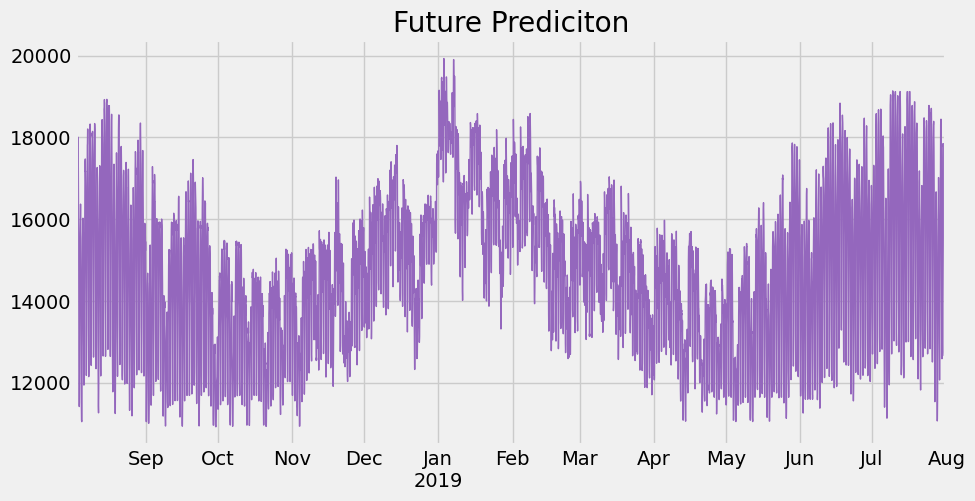

In [23]:
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title="Future Prediciton")
plt.show()

##5.2 Forecast on Test Set

<ipython-input-24-f9dc1d00e86b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


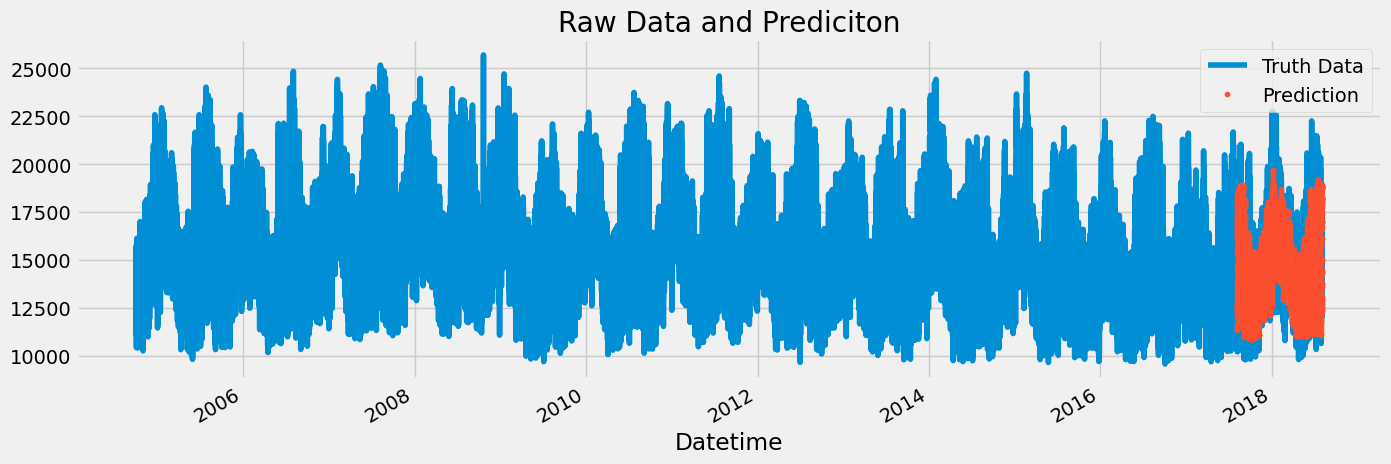

In [24]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediciton')
plt.show()

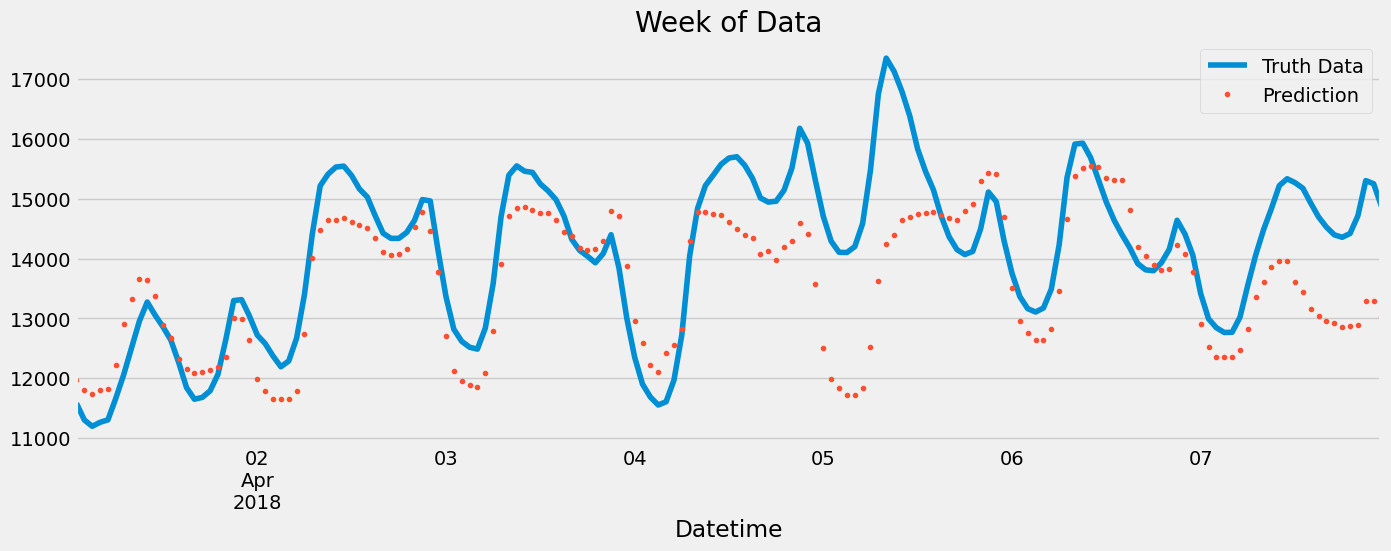

In [26]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15,5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1437.64


##5.3 Calculate Error

look at the worst and best predicted days



In [28]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-12-31    4659.166992
2017-12-28    4315.389567
2018-01-17    3606.385661
2018-01-02    3472.320801
2018-01-18    3223.654093
2017-12-27    2996.018311
2018-07-01    2903.253011
2018-01-14    2892.689535
2018-06-18    2835.916463
2018-01-03    2824.132161
Name: error, dtype: float64

In [29]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2018-03-29    167.712850
2018-06-23    175.756022
2017-10-25    185.138794
2018-03-04    205.256755
2018-03-30    218.405640
Name: error, dtype: float64

#6. Save Model

In [30]:
reg.save_model('AEP Model.json')

In [31]:
!ls -lh

total 588K
-rw-r--r-- 1 root root 578K Jun 15 06:50 'AEP Model.json'
drwx------ 5 root root 4.0K Jun 15 06:12  drive
drwxr-xr-x 1 root root 4.0K Jun 13 17:32  sample_data


##6.1 Load and test model saved

In [32]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('AEP Model.json')

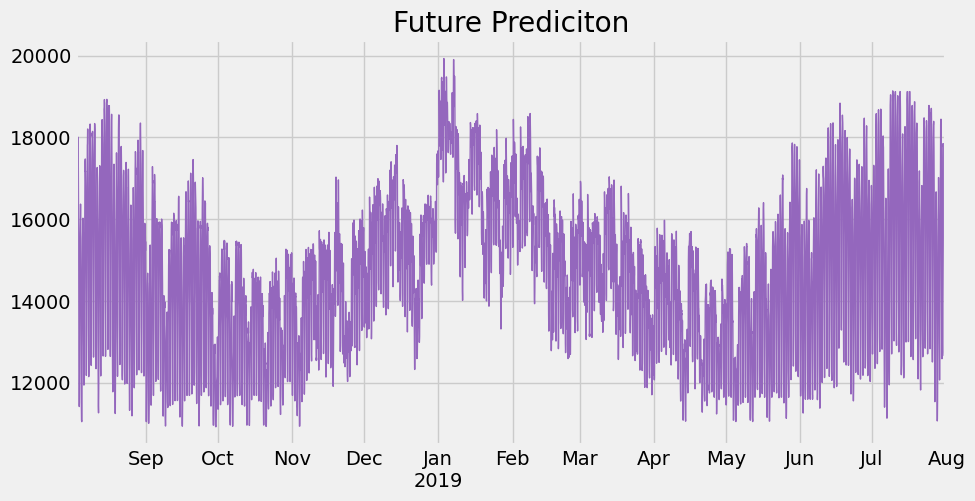

In [33]:
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10,5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title="Future Prediciton")
plt.show()

#End